### Getting set up

First, we must load the dataframe.

In [1]:
%matplotlib inline
import pandas as pd
df = pd.read_pickle('unpack_benchmark.dataframe')

We first seek to evaluate linearity (in the number of iterations). We can evaluate this for a given parameter configuration in the following way. First, we define a filtering dictionary used to constrain the dataframe.

In [2]:
filter_dict = {
    'access_pattern': 'independent',
    'complexity': 'complex',
    'column': 'nocolumn',
    'type': 'std::tuple<double, double, double, double>',
    'orientation': 'soa',
    'container_size': 1048576
}

Before we actually filter the dataset, we can take a look at the type of data which will be returned.

In [3]:
import df_plot
import pprint
pp = pprint.PrettyPrinter(indent=2)
unique = df_plot.unique_set(df)
pp.pprint(df_plot.get_selection_type(unique, filter_dict))

Querying with this filter will yield data with these dimensions unspecified:

{ 'benchmarking_tool': array(['chrono_benchmark'], dtype=object),
  'compiler': array(['g++-7.1'], dtype=object),
  'container': array(['vector'], dtype=object),
  'iterations': array([  32768,      32,       1, 1048576,    1024]),
  'optimization': array(['O3'], dtype=object),
  'run_id': array(['1'], dtype=object),
  'system_memory': array(['64GB'], dtype=object),
  'system_os': array(['Red Hat Enterprise Linux Server 6.9 (Santiago)'], dtype=object),
  'system_processor': array(['Intel(R) Xeon(R) CPU E5-2680 @ 2.70GHz'], dtype=object)}


### Testing for linearity (single case)

We can see in this case the only dimension with size of more than 1 is iterations. This is exctly what we want for assessing linearity (or lack thereof) through this dimension. Let's go ahead and filter our dataframe and determine a best fit line for the data.

x: [1, 32, 1024, 32768]
y: [0.09778025, 2.4766686, 73.359947, 2497.6101]
R2 score: 0.99999670
An R2 of 1 is a perfect fit. Range: (-infty, 1]


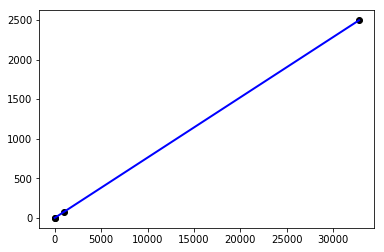

In [4]:
selection = df_plot.filter_df(filter_dict, df)
x, y = df_plot.xy(selection, 'iterations', 'timing', sortx=True)
print('x: ' + str(x))
print('y: ' + str(y))
df_plot.linearity_test(x, y, plot=True)

This shows how linearity testing will work for each configuration. We'll now go through to verify that every configuration displays the same type of linearity.

### Testing for linearity (all configurations)

In [5]:
df_plot.linearity_test_all(unique)

yes?
{'system_os': 'Red Hat Enterprise Linux Server 6.9 (Santiago)', 'system_processor': 'Intel(R) Xeon(R) CPU E5-2680 @ 2.70GHz', 'system_memory': '64GB', 'compiler': 'g++-7.1', 'optimization': 'O3', 'benchmarking_tool': 'chrono_benchmark', 'orientation': 'soa', 'container': 'vector', 'type': 'std::tuple<int>', 'access_pattern': 'independent', 'complexity': 'simple', 'column': 'nocolumn', 'container_size': 128}
11592
